In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dotenv
import torch.nn.functional as F

dotenv.load_dotenv()

def gather_run_histories(columns, rows, lines, filters, runs, y_axis):
    unique_columns, unique_rows, unique_lines = set(), set(), set()
    for run in runs:
        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        unique_columns.add(run.config[columns])
        unique_rows.add(run.config[rows])
        unique_lines.add(run.config[lines])

    unique_columns = sorted(list(unique_columns))
    unique_rows = sorted(list(unique_rows))
    unique_lines = sorted(list(unique_lines))
    print(unique_columns, unique_rows, unique_lines)

    series_dict = {}

    for run in runs:
        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        row_label = run.config[rows]
        column_label = run.config[columns]

        i = unique_rows.index(row_label)
        j = unique_columns.index(column_label)

        historys = run.history(keys=y_axis).set_index('_step')
        mean_series = historys.mean(axis=1)
        mean_series.name = run.config['seed']
        if (i, j) not in series_dict:
            series_dict[(i, j)] = {}

        if run.config[lines] not in series_dict[(i, j)]:
            series_dict[(i, j)][run.config[lines]] = mean_series.to_frame()
        else:
            series_dict[(i, j)][run.config[lines]][mean_series.name] = mean_series

    y_lines = [f"{s.split('/')[0]} {s.split('/')[1].upper()}" for s in y_axis]
    title = f'Comparing {str.join(", ", y_lines)} over {columns} and {rows} for different {lines}'

    return unique_columns, unique_rows, series_dict, title


def plot_metrics_in_grid(unique_columns, unique_rows, series_dict, title, label_prefix, x_limits):
    plot_size=7
    fig, axes = plt.subplots(len(unique_rows), len(unique_columns), figsize=(plot_size*len(unique_columns), plot_size*len(unique_rows)))
    for (i, j), graph_data in series_dict.items():
        row_label, column_label = unique_rows[i], unique_columns[j]
        for line_label, df_series in graph_data.items():
            df_series.ffill(inplace=True)
            mean_series = df_series.mean(axis=1)
            std_series = df_series.std(axis=1)
            axes[i, j].fill_between(mean_series.index, mean_series - std_series, mean_series + std_series, alpha=0.2)
            axes[i, j].plot(mean_series, label=f"{label_prefix}{line_label}")

        if j == 0:
            axes[i, j].set_ylabel(row_label)
        if i == 0:
            axes[i, j].set_title(column_label)
        axes[i, j].set_ylim(0)
        axes[i, j].set_xlim(*x_limits)
        axes[i, j].legend()
        # axes[i, j].set_yscale('log')

    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f'./out/plots/baselines/grid_{title}.pdf')
    plt.show()


def plot_metrics(unique_columns, unique_rows, series_dict, title, label_prefix, x_limits):
    # Plot the metrics in a single plot and average over seeds, columns and rows, just like the grid plot
    # Average the different seeds, columns and rows such that a pingle plot with multiple lines of just line_label is created
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    line_dict = {}
    for (i, j), graph_data in series_dict.items():
        row_label, column_label = unique_rows[i], unique_columns[j]
        for line_label, df_series in graph_data.items():
            if line_label not in line_dict:
                line_dict[line_label] = [df_series]
            else:
                line_dict[line_label].append(df_series)

    for line_label, df_series_list in line_dict.items():
        df_series = pd.concat(df_series_list, axis=1, join='inner')
        # df_series.ffill(inplace=True)
        mean_series = df_series.mean(axis=1)
        std_series = df_series.std(axis=1)
        ax.fill_between(mean_series.index, mean_series - std_series, mean_series + std_series, alpha=0.2)
        ax.plot(mean_series, label=f"{label_prefix}{line_label}")

    ax.set_xlim(*x_limits)
    ax.legend()
    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f'./out/plots/baselines/all_{title}.pdf')
    plt.show()

## CREATE TABLES

def gather_final_metrics_by_parameters(columns, rows, metrics, variable, filters, runs, variables_other_sorted=None, specific_seed=None):
    history_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    runs_found = 0
    for run in runs:
        if specific_seed is not None and run.config['seed'] != specific_seed:
            continue

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        run_column = str(run.config[columns]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        run_row = str(run.config[rows]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        run_variable = str(run.config[variable]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        run_metric = [run.summary[metric] for metric in metrics]
        # run_metric = { metric: run.summary[metric] for metric in metrics}
        run_seed = run.config['seed']

        if (run_column, run_row, run_variable) not in history_dict:
            history_dict[(run_column, run_row, run_variable)] = [run_metric]
        else:
            history_dict[(run_column, run_row, run_variable)].append(run_metric)
        runs_found += 1
    
    print(f'Found {runs_found} runs with metrics: {history_dict}')

    unique_columns = sorted(list(set([column for column, _, _ in history_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in history_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in history_dict.keys()])))
    if variables_other_sorted is not None:
        unique_variables = variables_other_sorted

    print(unique_columns, unique_rows, unique_variables)

    # Create a table with the average metrics for each variable
    table = np.zeros((len(unique_columns), len(unique_rows), len(unique_variables), len(metrics)*2))
    for j, row in enumerate(unique_rows):
        for i, column in enumerate(unique_columns):
            for k, variable in enumerate(unique_variables):
                if (column, row, variable) in history_dict:
                    table[i, j, k, 0:2] = np.mean(history_dict[(column, row, variable)], axis=0)
                    if len(history_dict[(column, row, variable)]) > 1:
                        table[i, j, k, 2:4] = np.std(history_dict[(column, row, variable)], axis=0)
                    else:
                        table[i, j, k, 2:4] = np.ones(2) * - 1 # If there is only one seed, the std is -1 to indicate that there is no std
                else:
                    table[i, j, k, :] = np.nan
    return table, unique_columns, unique_rows, unique_variables


def print_latex_table_input_target(table, unique_columns, unique_rows, unique_variables, variable_name=''):
    print("\\begin{table*}[]")
    print("\\centering")
    print("\\resizebox{\linewidth}{!}{")
    print("\\begin{tabular}{l|l" + "|cc" * len(unique_columns) + "}")
    print("\\toprule")
    print("      & Dataset                 & \\multicolumn{2}{c}{Electricity 370} & \\multicolumn{2}{c}{KDDCup} & \\multicolumn{2}{c}{London Smartmeter} & \\multicolumn{2}{c}{TNO Electricity} \\\\")
    dataset_headers = " & ".join([f"\\multicolumn{{2}}{{c}}{{{col}}}" for col in unique_columns])
    print(f"      & REPLACE                 & {dataset_headers} \\\\")
    print("\\midrule")

    # print(f"Model & {variable_name} & Input            & Target           & Input       & Target       & Input             & Target            & Input            & Target           \\\\")
    print(f"Model & {variable_name} & {'           & '.join(['Input & Target'] * len(unique_columns))} \\\\")
    print("\\midrule")

    def add_bold_if_min(number_value, string, minimum):
        if number_value == minimum:
            return "\\textbf{" + str(string) + "}"
        return str(string)
    
    def format_mean_std_value(value, std):
        if value < 1e-3:
            if std > 0:
                return f"{value:.1E}$\pm${std:.1E}".replace('E', 'e')
            return f"{value:.1E}".replace('E', 'e')
        if std > 0:
            return f"{value:.3f}$\pm${std:.3f}"
        return f"{value:.3f}"
    
    for j, row in enumerate(unique_rows):
        for k, variable in enumerate(unique_variables):
            if k == 0:
                row_values = [f"{row.replace('_Predictor', '')}\t& {variable}\t"]
            else:
                row_values = [f"\t& {variable}\t"]
            for i, column in enumerate(unique_columns):
                # Assuming last dimension is for mean values and we want the first element
                input_mean_value, target_mean_value = table[i, j, k, 0], table[i, j, k, 1]
                input_std_value, target_std_value = table[i, j, k, 2], table[i, j, k, 3]
                # If the input mean or target mean are the minimum value then it should be printed in bold with \textbf{}
                if not np.isnan(input_mean_value):
                    row_string_value = f''
                    row_string_value += add_bold_if_min(input_mean_value, format_mean_std_value(input_mean_value, input_std_value), np.nanmin(table[i, j, :, 0]))
                    row_string_value += " & "
                    row_string_value += add_bold_if_min(target_mean_value, format_mean_std_value(target_mean_value, target_std_value), np.nanmin(table[i, j, :, 1]))
                    row_values.append(row_string_value)
                else:
                    row_values.append("N/A & N/A")
            print(" & ".join(row_values) + " \\\\")
        if j != len(unique_rows) - 1:
            print("\\midrule")

    print('\\bottomrule')
    print('\\end{tabular}}')
    print('\\caption{}')
    print('\\end{table*}')

def print_latex_table_input_only(table, unique_columns, unique_rows, unique_variables, variable_name=''):
    header_row = " & " + " & ".join(unique_columns) + " \\\\ \\hline"

    print("\\begin{table*}[]")
    print("\\centering")
    print("\\resizebox{\linewidth}{!}{")
    # Modify the column definitions in LaTeX from two columns per dataset to one
    print("\\begin{tabular}{l|l" + "|c" * len(unique_columns) + "}")
    print("\\toprule")
    # Remove 'Target' from the column header
    # dataset_headers = " & ".join([f"\\multicolumn{{1}}{{c}}{{{col}}}" for col in unique_columns])
    # print(f"      & Dataset                 & {dataset_headers} \\\\")
    print("      & Dataset                 & \\multicolumn{1}{c}{Electricity 370} & \\multicolumn{1}{c}{KDDCup} & \\multicolumn{1}{c}{London Smartmeter} & \\multicolumn{1}{c}{TNO Electricity} \\\\")

    print("\\midrule")

    print(f"Model & {variable_name} & " + " & ".join(["Input" for _ in unique_columns]) + " \\\\")
    print("\\midrule")
    
    for j, row in enumerate(unique_rows):
        for k, variable in enumerate(unique_variables):
            if k == 0:
                row_values = [f"{row}\t& {variable}\t"]
            else:
                row_values = [f"\t& {variable}\t"]
            for i, column in enumerate(unique_columns):
                input_mean_value, input_std_value = table[i, j, k, 0], table[i, j, k, 2]
                if not np.isnan(input_mean_value):
                    row_string_value = f''
                    if input_mean_value == np.nanmin(table[i, j, :, 0]):
                        row_string_value += "\\textbf{"
                    if input_mean_value < 1e-3:
                        row_string_value += f"{input_mean_value:.1E}$\pm${input_std_value:.1E}".replace('E', 'e') 
                    else:
                        row_string_value += f"{input_mean_value:.3f}$\pm${input_std_value:.3f}"
                    if input_mean_value == np.nanmin(table[i, j, :, 0]):
                        row_string_value += "}"
                    row_values.append(row_string_value)
                else:
                    row_values.append("N/A")
            print(" & ".join(row_values) + " \\\\")
        if j != len(unique_rows) - 1:
            print("\\midrule")

    print('\\bottomrule')
    print('\\end{tabular}}')
    print('\\caption{}')
    print('\\end{table*}')


# PLOT RECONSTRUCTIONS

from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Bbox
import wandb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import torch
import dotenv
import json
import os

def gather_run_reconstructions(dataset_seed, columns, rows, variables, filters, runs, replace_dict={}):
    def dataframe_keys_and_should_skip_run(run):
        if run.config['dataset'] not in dataset_seed or run.config['seed'] != dataset_seed[run.config['dataset']]:
            return [], True

        dataframe_keys = []
        for key in run.summary.keys():
            if 'dataframe' in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            return [], True

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            return [], True
        return dataframe_keys, False

    def replace_predictor_name(runs_config, name):
        run_config_value = runs_config[name]
        for key, value in replace_dict.items():
            if isinstance(run_config_value, str):
                run_config_value = run_config_value.replace(key, value)
        if name == 'dataset':
            return f"{run_config_value} ({dataset_seed[runs_config[name]]})"
        if name == 'model':
            return run_config_value.replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        return run_config_value

    reconstructed_data_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    for run in runs:
        dataframe_keys, should_skip_run = dataframe_keys_and_should_skip_run(run)
        if should_skip_run:
            continue

        run_column = replace_predictor_name(run.config, columns)
        run_row = replace_predictor_name(run.config, rows)
        run_variable = replace_predictor_name(run.config, variables)

        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info['path'])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, 'r') as f:
            data = json.load(f)
        reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])
        if (run_column, run_row, run_variable) not in reconstructed_data_dict:
            reconstructed_data_dict[(run_column, run_row, run_variable)] = reconstructed_data

    print(reconstructed_data_dict.keys())

    unique_columns = sorted(list(set([column for column, _, _ in reconstructed_data_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in reconstructed_data_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in reconstructed_data_dict.keys()])))

    return reconstructed_data_dict, unique_columns, unique_rows, unique_variables

def plot_single_batch_reconstructions_in_grid(series_dict, unique_columns, unique_rows, unique_variables, extra_title="", legend_loc='upper left', column_offset=0.0, plot_size_width=2, plot_size_height=0.33, legend_font_size=7):
    fig = plt.figure(figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)*len(unique_variables)))
    subfigs = fig.subfigures(len(unique_rows), len(unique_columns))
    if len(unique_rows) == 1 and len(unique_columns) == 1:
        subfigs = np.array([[subfigs]])
    elif len(unique_rows) == 1:
        subfigs = np.array([subfigs])
    elif len(unique_columns) == 1:
        subfigs = np.array([subfigs]).T

    colors = plt.cm.tab10.colors

    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            subfig = subfigs[i, j]
            subfig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.9, bottom=0.05)
            axes_1 = subfig.subplots(len(unique_variables), 1, sharex=True, sharey=True)
            if len(unique_variables) == 1:
                axes_1 = [axes_1]
            for k, variable in enumerate(unique_variables):
                if (column_label, row_label, variable) in series_dict:
                    reconstructed_data = series_dict[(column_label, row_label, variable)]
                    n_batches = len(reconstructed_data.columns) // 4
                    for b in range(n_batches):
                        df_plot = reconstructed_data[[f'batch_inputs_{b}_0', f'batch_targets_{b}']]
                        batch_colors = [colors[(2*b) % 10], colors[(2*b+2) % 10]]
                        df_plot.plot(ax=axes_1[k], legend=False, color=batch_colors)

                    for b in range(n_batches):
                        df_plot = reconstructed_data[[f'dummy_inputs_{b}_0', f'dummy_targets_{b}']]
                        dummy_colors = [colors[(2*b+1) % 10], colors[(2*b+3) % 10]]
                        df_plot.plot(ax=axes_1[k], legend=False, style=['--', '--'], color=dummy_colors)

                    # reconstructed_data.plot(ax=axes_1[k], legend=False)
                    dummy_handle = mlines.Line2D([], [], color='none', label=variable)
                    axes_1[k].legend(handles=[dummy_handle], loc=legend_loc, handlelength=0, handletextpad=0, fancybox=True, fontsize=legend_font_size)

                axes_1[k].set_ylim(-0.1, 1.1)
                axes_1[k].set_yticks([])
                axes_1[k].set_xticks([])

            if i == 0:
                subfig.text(0.5, 1.0+column_offset, column_label, ha='center', va='top')
            if j == 0:
                subfig.text(0.0, 0.5, row_label, ha='left', va='center', fontsize=8, rotation=90)

    fig.savefig(f'./out/plots/reconstructions/grid_reconstructions_{extra_title}.pdf')
    plt.show()


from src.attack_time_series_utils import SMAPELoss

def get_batch_sample_mapping(original_data, dummy_data):
    batch_size = original_data.shape[0]
    sample_mapping = np.arange(0, batch_size)
    for i in range(batch_size):
        smallest_loss = float('inf')
        for j in range(batch_size):
            loss = F.l1_loss(original_data[i], dummy_data[j]).detach().item()  # instead of MSE because L1 is less sensitive to outliers
            if loss < smallest_loss:
                smallest_loss = loss
                sample_mapping[i] = j
    # Check if sample_mapping contains duplicates; if so, reset it
    if len(np.unique(sample_mapping)) != batch_size:
        sample_mapping = np.arange(0, batch_size)
    return sample_mapping


def get_batch_sample_mapping_from_dataframe(reconstructed_data, batch_size):
    original_inputs = torch.tensor(reconstructed_data[[f'batch_inputs_{i}_0' for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    dummy_inputs = torch.tensor(reconstructed_data[[f'dummy_inputs_{i}_0' for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    original_targets = torch.tensor(reconstructed_data[[f'batch_targets_{i}' for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    dummy_targets = torch.tensor(reconstructed_data[[f'dummy_targets_{i}' for i in range(batch_size)]].dropna().values.T).unsqueeze(-1)
    # print(original_inputs.shape, dummy_inputs.shape, original_targets.shape, dummy_targets.shape)

    standard_mapping = np.arange(0, batch_size)
    input_sample_mapping = get_batch_sample_mapping(original_inputs, dummy_inputs)
    target_sample_mapping = get_batch_sample_mapping(original_targets, dummy_targets)

    sample_mapping = np.arange(0, batch_size)
    if not (standard_mapping == input_sample_mapping).all():
        sample_mapping = input_sample_mapping
    if (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        sample_mapping = target_sample_mapping
    if not (standard_mapping == input_sample_mapping).all() and not (standard_mapping == target_sample_mapping).all():
        if not (input_sample_mapping == target_sample_mapping).all():
            raise ValueError('Input and target sample mappings are not equal while being different from the standard mapping.')
    return sample_mapping, original_inputs, dummy_inputs, original_targets, dummy_targets


def gather_final_metrics_from_reconstructions_by_parameters(columns, rows, metric, variable, filters, runs, variables_other_sorted=None):
    history_dict = {}
    if isinstance(runs, list):
        runs = [run for run_list in runs for run in run_list]

    runs_found = 0
    for run in runs:
        dataframe_keys = []
        for key in run.summary.keys():
            if 'dataframe' in key:
                dataframe_keys.append(key)
        if len(dataframe_keys) == 0:
            continue

        continue_next_run = [False for _ in range(len(filters))]
        for i, filter_dict in enumerate(filters):
            if not np.array([v(run.config[k]) for k, v in filter_dict.items() if k in run.config]).all():
                continue_next_run[i] = True
        if np.array(continue_next_run).all():
            continue

        run_column = str(run.config[columns]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        run_row = str(run.config[rows]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        run_variable = str(run.config[variable]).replace('JitGRU_Predictor', 'GRU_Predictor').replace('_Predictor', '')
        
        dataframe_info = run.summary[dataframe_keys[0]]
        file = run.file(dataframe_info['path'])
        if not os.path.exists(file.name):
            file.download(replace=True)
        with open(file.name, 'r') as f:
            data = json.load(f)
        reconstructed_data = pd.DataFrame(data=data['data'], columns=data['columns'])

        sample_mapping, original_inputs, dummy_inputs, original_targets, dummy_targets = get_batch_sample_mapping_from_dataframe(reconstructed_data, run.config['batch_size'])
        
        # Calculate the metrics
        run_metric = [metric(dummy_inputs[sample_mapping], original_inputs).item(), metric(dummy_targets[sample_mapping], original_targets).item()]

        if (run_column, run_row, run_variable) not in history_dict:
            history_dict[(run_column, run_row, run_variable)] = [run_metric]
        else:
            history_dict[(run_column, run_row, run_variable)].append(run_metric)
        runs_found += 1

    print(f'Found {runs_found} runs with reconstructions')
    unique_columns = sorted(list(set([column for column, _, _ in history_dict.keys()])))
    unique_rows = sorted(list(set([row for _, row, _ in history_dict.keys()])))
    unique_variables = sorted(list(set([variable for _, _, variable in history_dict.keys()])))
    if variables_other_sorted is not None:
        unique_variables = variables_other_sorted

    print(unique_columns, unique_rows, unique_variables)

    # Create a table with the average metrics for each variable
    table = np.zeros((len(unique_columns), len(unique_rows), len(unique_variables), 4))
    for j, row in enumerate(unique_rows):
        for i, column in enumerate(unique_columns):
            for k, variable in enumerate(unique_variables):
                if (column, row, variable) in history_dict:
                    table[i, j, k, 0:2] = np.mean(history_dict[(column, row, variable)], axis=0)
                    if len(history_dict[(column, row, variable)]) > 1:
                        table[i, j, k, 2:4] = np.std(history_dict[(column, row, variable)], axis=0)
                    else:
                        table[i, j, k, 2:4] = np.ones(2) * - 1 # If there is only one seed, the std is -1 to indicate that there is no std
                else:
                    table[i, j, k, :] = np.nan
    return table, unique_columns, unique_rows, unique_variables

def plot_multi_batch_reconstructions_in_grid(series_dict, unique_columns, unique_rows, unique_batch_sizes, extra_title="", legend_loc='upper left', column_offset=0.0, plot_size_width=2, plot_size_height=0.33, legend_font_size=7):
    fig = plt.figure(figsize=(plot_size_width*len(unique_columns), plot_size_height*len(unique_rows)*sum(unique_batch_sizes)))
    subfigs = fig.subfigures(len(unique_rows), len(unique_columns))
    if len(unique_rows) == 1 and len(unique_columns) == 1:
        subfigs = np.array([[subfigs]])
    elif len(unique_rows) == 1:
        subfigs = np.array([subfigs])
    elif len(unique_columns) == 1:
        subfigs = np.array([subfigs]).T

    for i, row_label in enumerate(unique_rows):
        for j, column_label in enumerate(unique_columns):
            subfig = subfigs[i, j]

            batch_size = [bs for bs in unique_batch_sizes if (column_label, row_label, bs) in series_dict][0]

            subfig.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.9, bottom=0.05)
            axes = subfig.subplots(max(unique_batch_sizes), 1, sharex=True, sharey=True)
            
            if (column_label, row_label, batch_size) in series_dict:
                reconstructed_data = series_dict[(column_label, row_label, batch_size)]
                sample_mapping, batch_inputs, dummy_inputs, batch_targets, dummy_targets = get_batch_sample_mapping_from_dataframe(reconstructed_data, batch_size)
                original_x_axis = np.arange(0, batch_inputs.shape[1]+batch_targets.shape[1])
                for b, d in enumerate(sample_mapping):
                    ax = axes[b] if batch_size > 1 else axes
                    ax.plot(original_x_axis[:batch_inputs.shape[1]], batch_inputs[b, :].detach().cpu().numpy())
                    ax.plot(original_x_axis[:batch_inputs.shape[1]], dummy_inputs[d, :].detach().cpu().numpy())

                    ax.plot(original_x_axis[batch_inputs.shape[1]:], batch_targets[b, :].detach().cpu().numpy())
                    ax.plot(original_x_axis[batch_inputs.shape[1]:], dummy_targets[d, :].detach().cpu().numpy())

                    dummy_handle = mlines.Line2D([], [], color='none', label=f'Sample {b}')
                    ax.legend(handles=[dummy_handle], loc=legend_loc, handlelength=0, handletextpad=0, fancybox=True, fontsize=legend_font_size)
                    ax.set_ylim(-0.1, 1.1)
                    ax.set_yticks([])
                    ax.set_xticks([])

            if i == 0:
                subfig.text(0.5, 1.0+column_offset, column_label, ha='center', va='top')
            if j == 0:
                subfig.text(0.0, 0.5, row_label, ha='left', va='center', fontsize=8, rotation=90)

    fig.savefig(f'./out/plots/reconstructions/grid_reconstructions_{extra_title}.pdf', bbox_inches='tight')
    plt.show()

ts_inverse_project_name = "capsar-meijer/tno-fl-ts-inverse"

api = wandb.Api()

In [ ]:
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_dilate_vs_l1_regularization_5-6-2024', # TCN Results
    },
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='inversion_regularization_loss', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='inversion_regularization_term', filters=filters, runs=runs_ts_inverse)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Regularization')


dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 43,
    'tno_electricity': 43,
}

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_dilate_vs_l1_regularization_5-6-2024', # TCN Results
        'inversion_regularization_loss': lambda x: x == '-',
    },
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='inversion_regularization_term', variables='batch_size', filters=filters, runs=runs_ts_inverse, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_model', legend_loc='lower right', plot_size_height=0.42, plot_size_width=2.5)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_dilate_vs_l1_regularization_5-6-2024', # TCN Results
        'inversion_regularization_loss': lambda x: x == 'dilate',
    },
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='inversion_regularization_term', variables='batch_size', filters=filters, runs=runs_ts_inverse, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_model', legend_loc='lower right', plot_size_height=0.42, plot_size_width=2.5)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_dilate_vs_l1_regularization_5-6-2024', # TCN Results
        'inversion_regularization_loss': lambda x: x == 'l1',
    },
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='inversion_regularization_term', variables='batch_size', filters=filters, runs=runs_ts_inverse, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_model', legend_loc='lower right', plot_size_height=0.42, plot_size_width=2.5)


filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_dilate_parameters_regularization_6-6-2024', # TCN Results
    },
]

In [ ]:
# Show the learned priors in terms of quantiles.
experiment_names = ["ts-inverse_quantile_regularization_10-6-2024"]
runs_ts_inverse = api.runs(ts_inverse_project_name, filters={"$or": [{"config.experiment_name": name} for name in experiment_names]})
print(f"Found {len(runs_ts_inverse)} runs for Learned Prior Regularization")

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_quantile_regularization_10-6-2024',
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='inversion_regularization_loss', rows='inversion_regularization_term_inputs', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='inversion_regularization_term_targets', filters=filters, runs=runs_ts_inverse)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Targets Term')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_quantile_regularization_10-6-2024',
    }
]
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'euclidean': 'Euclidean',
    '1_norm_1_cosine': 'Cosine + Norm'
}
dataset_seed_dict = {
    'electricity_370': 10,
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='inversion_regularization_term_targets', rows='inversion_regularization_term_inputs', variables='batch_size', filters=filters, runs=runs_ts_inverse, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_ts_learned_quantile_regularization', plot_size_width=2.5, plot_size_height=0.45, legend_loc='best')
# ## ^^ IN THE PAPER

# # ## BELOW IS FOR THESIS
dataset_seed_dict = {
    'electricity_370': 10,
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='inversion_regularization_term_targets', rows='inversion_regularization_term_inputs', variables='batch_size', filters=filters, runs=runs_ts_inverse, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_ts_learned_quantile_regularization', plot_size_width=2.5, plot_size_height=0.45, legend_loc='best')


In [ ]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    # {
    #     'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_gradient_loss_x_batch_size_11-5-2024', # No Prior
    #     'gradient_loss': lambda x: x == 'l1' or x == 'cosine_dia' or x == 'euclidean',
    # },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_tcn_gradient_loss_with_prior_1-6-2024',
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')


# Plotting specific example for in the paper, showing target difference between L1 and Cosine
filters = [
    # {
    #     'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_gradient_loss_x_batch_size_11-5-2024', # Cosine_dia, L1 and 1_l1 + 0.0005_cosine
    #     'gradient_loss': lambda x: x == 'l1' or x == 'cosine_dia' or x == 'euclidean', 
    #     'batch_size': lambda x: x == 1,
    # },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_tcn_gradient_loss_with_prior_1-6-2024',
    }
]
dataset_seed_dict = {
    'electricity_370': 43,
    # 'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'euclidean': 'Euclidean',
    'TCN': 'TS-Inverse (TCN)',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_dataset_x_gradient_loss', plot_size_width=2.5, plot_size_height=0.45, legend_loc='center')

In [ ]:
dataset_seed_dict = {
    'electricity_370': 10,
    'tno_electricity': 28,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'euclidean': 'Euclidean',
}

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_fcn_tcn_grad_loss_no_prior_3-6-2024',
        'model': lambda x: 'FCN' in x
    }
]
gradients_dict, u_columns, u_rows  = gather_run_gradients(dataset_seed=dataset_seed_dict, columns='gradient_loss', rows='dataset', filters=filters, runs=runs, replace_dict=replace_dict)
plot_gradients_in_grid(gradients_dict, u_columns, u_rows, extra_title='ts-inverse_fcn_gradient_loss', plot_size_width=6, plot_size_height=3, legend_loc='upper left', legend_font_size=13)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_fcn_tcn_grad_loss_no_prior_3-6-2024',
        'model': lambda x: 'CNN' in x
    }
]
gradients_dict, u_columns, u_rows  = gather_run_gradients(dataset_seed=dataset_seed_dict, columns='gradient_loss', rows='dataset', filters=filters, runs=runs, replace_dict=replace_dict)
plot_gradients_in_grid(gradients_dict, u_columns, u_rows, extra_title='ts-inverse_cnn_gradient_loss', plot_size_width=6, plot_size_height=3, legend_loc='upper left', legend_font_size=13)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_fcn_tcn_grad_loss_no_prior_3-6-2024',
        'model': lambda x: 'TCN' in x
    }
]
gradients_dict, u_columns, u_rows  = gather_run_gradients(dataset_seed=dataset_seed_dict, columns='gradient_loss', rows='dataset', filters=filters, runs=runs, replace_dict=replace_dict)
plot_gradients_in_grid(gradients_dict, u_columns, u_rows, extra_title='ts-inverse_tcn_gradient_loss', plot_size_width=6, plot_size_height=3, legend_loc='upper left', legend_font_size=13)

In [2]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_prior_regularization_4-6-2024',
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='inversion_regularization_loss', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='inversion_regularization_term', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')


# Plotting specific example for in the paper, showing target difference between L1 and Cosine
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_prior_regularization_4-6-2024',
    }
]
dataset_seed_dict = {
    'electricity_370': 43,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'euclidean': 'Euclidean',
    'TCN': 'TS-Inverse (TCN)',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_prior_regularization', plot_size_width=2.5, plot_size_height=0.45, legend_loc='center')

KeyboardInterrupt: 

# ts-inverse_cnn_tcn_gradient_sign_for_targets_11-5-2024

Found 1473 runs
Found 24 runs with metrics: {('tno_electricity', 'TCN', 'False'): [[0.5619688630104065, 0.07367231696844101], [0.465134471654892, 0.07995620369911194]], ('london_smartmeter', 'TCN', 'False'): [[0.12082399427890778, 0.08735349774360657], [0.14505431056022644, 0.019834265112876892]], ('electricity_370', 'TCN', 'False'): [[0.49340495467185974, 0.039724089205265045], [0.3446180820465088, 0.0576351098716259]], ('tno_electricity', 'CNN', 'False'): [[0.3133962154388428, 0.804229736328125], [0.29278111457824707, 0.8211333751678467]], ('london_smartmeter', 'CNN', 'False'): [[0.3901050090789795, 0.7236149311065674], [0.42312535643577576, 0.6398878693580627]], ('electricity_370', 'CNN', 'False'): [[0.107071191072464, 0.3720800578594208], [0.09992755949497224, 0.4171831011772156]], ('tno_electricity', 'TCN', 'True'): [[0.7383531332015991, 0.09976127743721008], [0.32868602871894836, 0.0501929447054863]], ('london_smartmeter', 'TCN', 'True'): [[0.21078935265541077, 0.0881509706377983

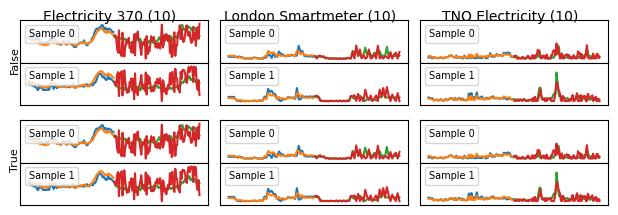

dict_keys([('TNO Electricity (10)', False, 2), ('London Smartmeter (10)', False, 2), ('Electricity 370 (10)', False, 2), ('TNO Electricity (10)', True, 2), ('London Smartmeter (10)', True, 2), ('Electricity 370 (10)', True, 2)])


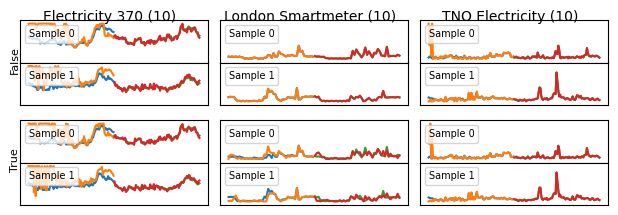

In [2]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_tcn_gradient_sign_for_targets_11-5-2024',
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='grad_signs_for_targets', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
}
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_tcn_gradient_sign_for_targets_11-5-2024',
        'model': lambda x: 'CNN' in x,
    }
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='grad_signs_for_targets', variables='batch_size', filters=filters, runs=runs, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_cnn_gradient_sign_targets', legend_loc='upper left', plot_size_height=0.5)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_cnn_tcn_gradient_sign_for_targets_11-5-2024',
        'model': lambda x: 'TCN' in x,
    }
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='grad_signs_for_targets', variables='batch_size', filters=filters, runs=runs, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_gradient_sign_targets', legend_loc='upper left', plot_size_height=0.5)

# ts-inverse_tcn_l1_dataset_x_batch_size_x_dropout_reg_12-5-2024

Found 1473 runs
Found 72 runs with reconstructions
['electricity_370', 'london_smartmeter', 'tno_electricity'] ['1', '2', '4'] ['0.0001', '0.001', '1e-05', '1e-06']
(3, 3, 4, 4)
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Dropout $\eta$ & Input & Target           & Input & Target           & Input & Target \\
\midrule
1	& 0.0001	 & 0.069$\pm$0.034 & 9.3e-04$\pm$5.9e-04 & 0.124$\pm$0.095 & 0.043$\pm$0.041 & 0.182$\pm$0.002 & 0.022$\pm$0.014 \\
	& 0.001	 & 0.077$\pm$0.048 & 0.001$\pm$0.000 & \textbf{0.056$\pm$0.005} & \textbf{0.007$\pm$0.001} & 0.222$\pm$0.035 & \textbf{0.020$\pm$0.017} \\
	& 1e-0

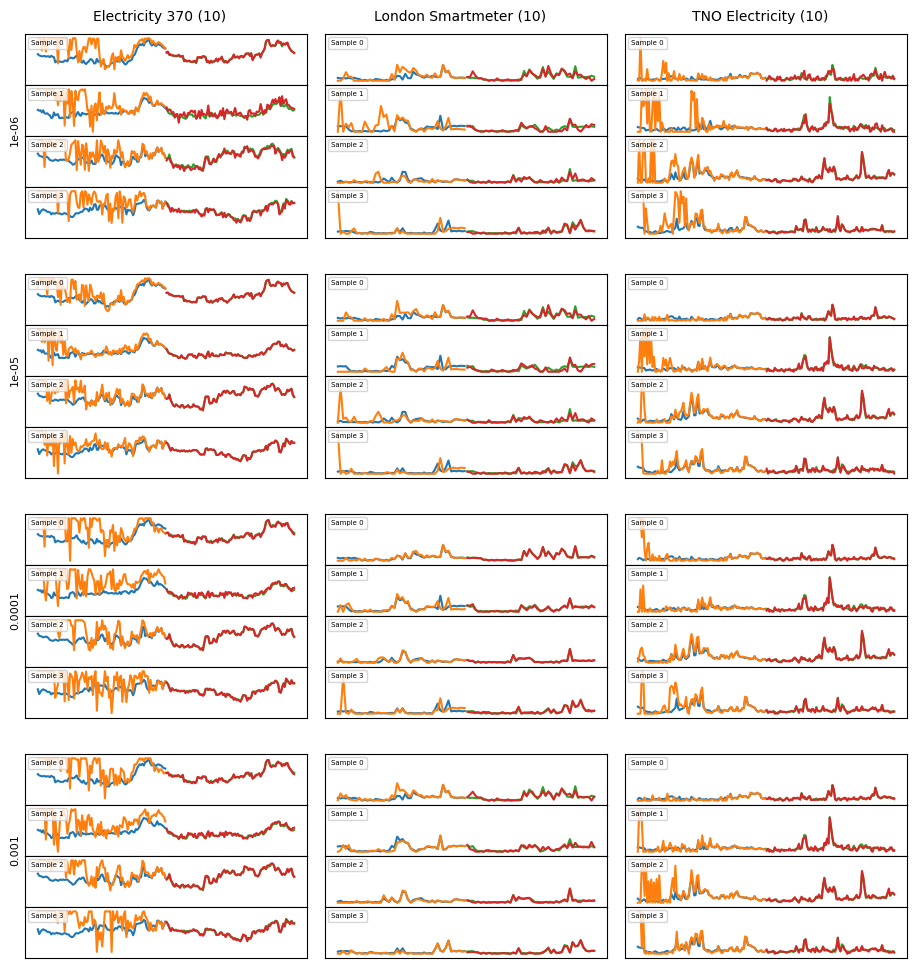

In [3]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_l1_dataset_x_batch_size_x_dropout_reg_12-5-2024',
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='dropout_probability_regularizer', filters=filters, runs=runs)
print(metric_table.shape)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Dropout $\eta$')

dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
}
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_l1_dataset_x_batch_size_x_dropout_reg_12-5-2024',
        'batch_size': lambda x: x == 4,
    }
]
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='dropout_probability_regularizer', variables='batch_size', filters=filters, runs=runs, replace_dict=replace_dict)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_dropout_reg_term', legend_loc='upper left', plot_size_width=3, plot_size_height=0.6, legend_font_size=5)

# filters = [
#     {
#         'experiment_name': lambda x: x == 'ts-inverse_cnn_tcn_gradient_sign_for_targets_11-5-2024',
#         'model': lambda x: 'TCN' in x,
#     }
# ]
# reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='grad_signs_for_targets', variables='batch_size', filters=filters, runs=runs, replace_dict=replace_dict)
# plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_gradient_sign_targets', legend_loc='upper left', plot_size_height=0.5)

# ts-inverse_dataset_after_effect_12-5-2024

Found 1473 runs


Found 24 runs with reconstructions
['electricity_370', 'london_smartmeter', 'tno_electricity'] ['TCN'] ['boxed', 'clamp_1', 'clamp_2', 'none']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & After Effect & Input & Target           & Input & Target           & Input & Target \\
\midrule
TCN	& boxed	 & 0.644$\pm$0.150 & \textbf{0.039$\pm$0.003} & 0.392$\pm$0.268 & 0.653$\pm$0.027 & 0.644$\pm$0.189 & \textbf{0.031$\pm$0.008} \\
	& clamp_1	 & \textbf{0.376$\pm$0.087} & 0.061$\pm$0.024 & 0.141$\pm$0.022 & 0.054$\pm$0.033 & 0.685$\pm$0.036 & 0.479$\pm$0.157 \\
	& clamp_2	 & 0.419$\pm$0.074 & 0.049$\pm$0.0

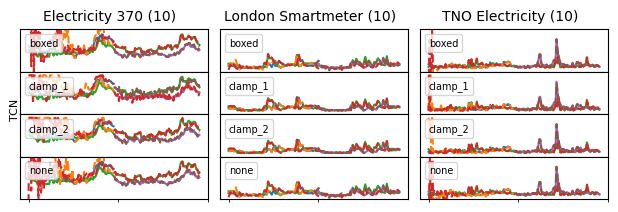

In [4]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_dataset_after_effect_12-5-2024',
        'batch_size': lambda x: x == 2
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='model', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='after_effect', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='After Effect')

dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='after_effect', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_fcn_after_effect_clamp2', legend_loc='upper left', plot_size_height=0.5)

# ts-inverse_tcn_dataset_x_inv_x_batch_size_19-5-2024

Found 1473 runs
Found 72 runs with reconstructions
['electricity_370', 'london_smartmeter', 'tno_electricity'] ['1', '2', '4', '8'] ['-1', '0', '0.01']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Inversion Term & Input & Target           & Input & Target           & Input & Target \\
\midrule
1	& -1	 & 0.063$\pm$0.030 & \textbf{9.0e-04$\pm$6.8e-04} & 0.094$\pm$0.033 & 0.012$\pm$0.006 & 0.166$\pm$0.036 & 0.021$\pm$0.019 \\
	& 0	 & 0.066$\pm$0.040 & 0.001$\pm$0.001 & 0.235$\pm$0.197 & 0.096$\pm$0.090 & 0.211$\pm$0.020 & 0.007$\pm$0.001 \\
	& 0.01	 & \textbf{0.058$\pm$0.039} & 9.9e-04$\pm$7.7e-04 &

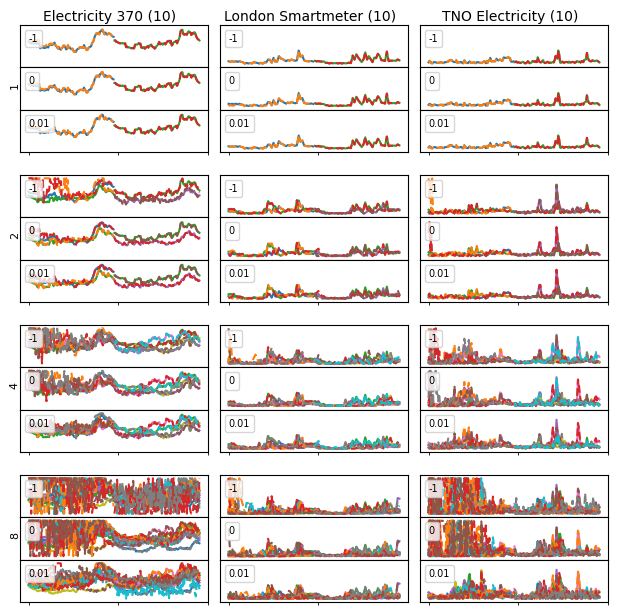

In [26]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_x_inv_x_batch_size_19-5-2024',
        'inversion_regularization_term': lambda x: x != 0.0001,
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='inversion_regularization_term', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Inversion Term')

dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='batch_size', variables='inversion_regularization_term', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_dataset_x_inv_x_batch_size_19-5-2024', legend_loc='upper left', plot_size_height=0.5)

# FCN, CNN and TCN comparison on gradient loss with Batch size = 4

If anything can be concluded from this 1 seed run is that the 0.1_l1_1_cosine works quite well for TCN attack.

Found 1473 runs
Found 42 runs with metrics: {('electricity_370', 'TCN', 'cosine_dia'): [[0.8374288082122803, 1.17413067817688], [0.5131895542144775, 0.3349379897117615]], ('electricity_370', 'FCN', 'cosine_dia'): [[0.4228024482727051, 0.5821903944015503], [0.12980131804943085, 0.5242583155632019]], ('electricity_370', 'CNN', 'cosine_dia'): [[0.24337562918663025, 0.5582257509231567], [0.11740756034851074, 0.5516442060470581]], ('electricity_370', 'TCN', 'l1'): [[0.7724522352218628, 0.47960394620895386], [0.3826846480369568, 0.22513484954833984]], ('electricity_370', 'FCN', 'l1'): [[0.3788575530052185, 0.622342050075531], [0.13376396894454956, 0.4368813931941986]], ('electricity_370', 'CNN', 'l1'): [[0.2433764934539795, 0.6588310599327087], [0.1165907308459282, 0.45441603660583496]], ('electricity_370', 'TCN', '1_l1_1_cosine'): [[0.798011302947998, 0.6124531030654907], [0.48917311429977417, 0.3587181270122528]], ('electricity_370', 'FCN', '1_l1_1_cosine'): [[0.3834547996520996, 0.6180097

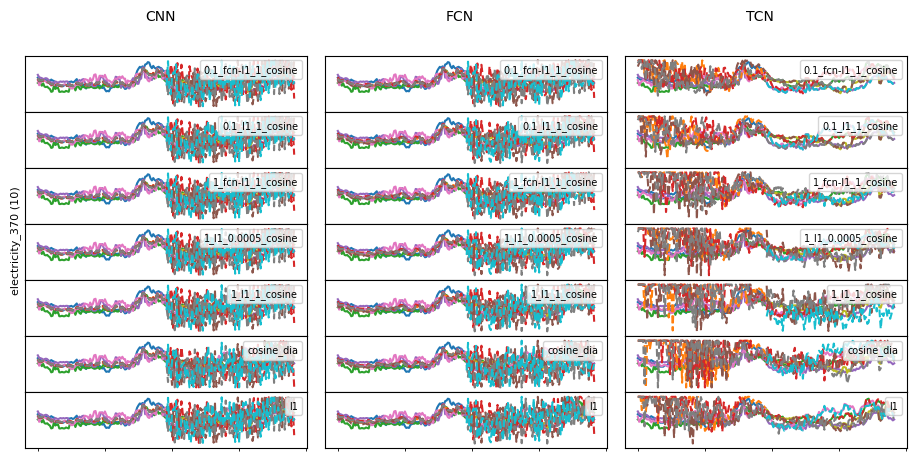

dict_keys([('TCN', 'cosine_dia', 4), ('FCN', 'cosine_dia', 4), ('CNN', 'cosine_dia', 4), ('TCN', 'l1', 4), ('FCN', 'l1', 4), ('CNN', 'l1', 4), ('TCN', '1_l1_1_cosine', 4), ('FCN', '1_l1_1_cosine', 4), ('CNN', '1_l1_1_cosine', 4), ('TCN', '1_l1_0.0005_cosine', 4), ('FCN', '1_l1_0.0005_cosine', 4), ('CNN', '1_l1_0.0005_cosine', 4), ('TCN', '0.1_l1_1_cosine', 4), ('FCN', '0.1_l1_1_cosine', 4), ('CNN', '0.1_l1_1_cosine', 4), ('TCN', '0.1_fcn-l1_1_cosine', 4), ('FCN', '0.1_fcn-l1_1_cosine', 4), ('CNN', '0.1_fcn-l1_1_cosine', 4), ('TCN', '1_fcn-l1_1_cosine', 4), ('FCN', '1_fcn-l1_1_cosine', 4), ('CNN', '1_fcn-l1_1_cosine', 4)])


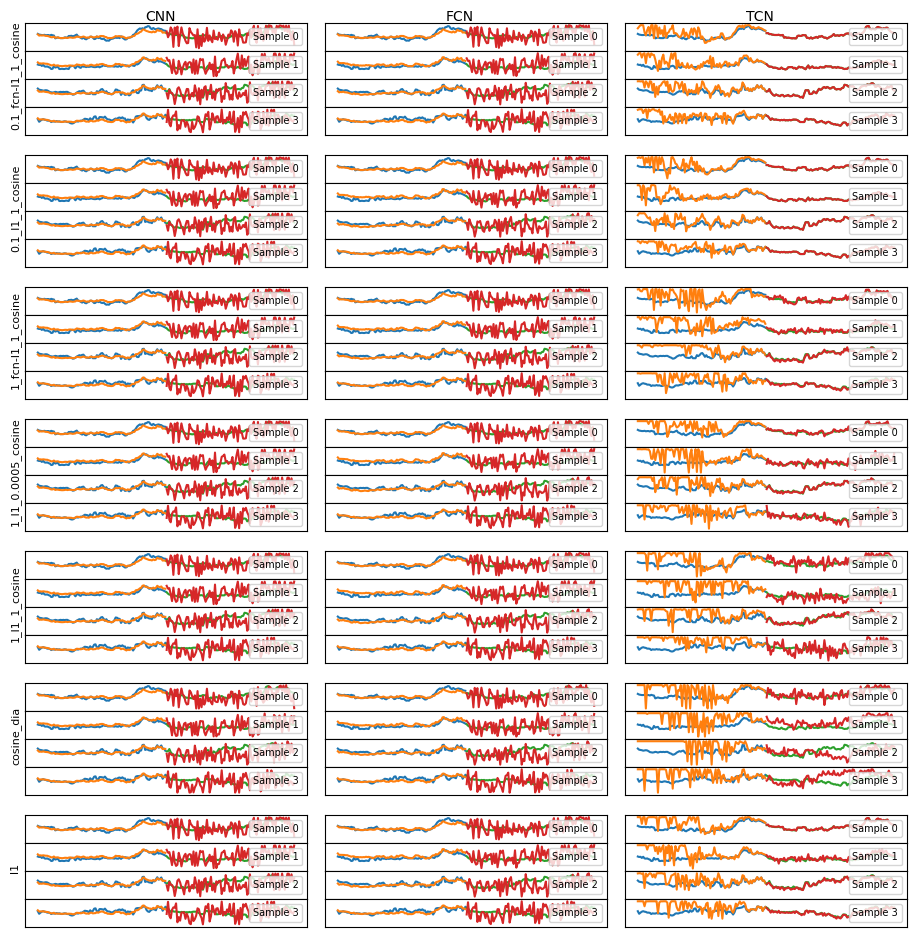

In [6]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_gradient_loss_x_batch_4_10-5-2024',
        # 'dataset': lambda x: x == 'electricity_370',
        # 'gradient_loss': lambda x: x == 'cosine_dia' or x == 'l1' or x == '1_l1_0.0005_cosine'
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')


metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='model', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='model', rows='dataset', variables='gradient_loss', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gradient_loss_x_batch_4', legend_loc='upper right', plot_size_width=3, plot_size_height=0.66)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='model', rows='gradient_loss', variables='batch_size', filters=filters, runs=runs)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='batch_ts-inverse_gradient_loss_x_model', legend_loc='upper right', plot_size_width=3)

# TCN Comparison of Gradient Losses on Electricity Datasets with Batch sizes = [1, 2, 4] and multiple seeds (10 & 43)

Found 1591 runs
Found 55 runs with reconstructions
['electricity_370', 'london_smartmeter', 'tno_electricity'] ['1', '2', '4'] ['cosine_dia', 'euclidean', 'l1']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Gradient Loss & Input & Target           & Input & Target           & Input & Target \\
\midrule
1	& cosine_dia	 & 0.238$\pm$0.024 & 0.170$\pm$0.020 & 0.658$\pm$0.341 & 0.272$\pm$0.011 & 0.791$\pm$0.194 & 0.265$\pm$0.040 \\
	& euclidean	 & 0.231$\pm$0.035 & 0.015$\pm$0.013 & 0.663$\pm$0.302 & 0.228$\pm$0.126 & 0.555$\pm$0.045 & 0.057$\pm$0.003 \\
	& l1	 & \textbf{0.107$\pm$0.072} & \textbf{0.00

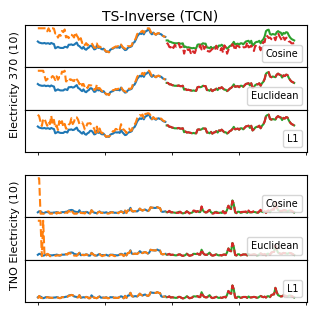

In [5]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_gradient_loss_x_batch_size_11-5-2024',
        'gradient_loss': lambda x: x == 'l1' or x == 'cosine_dia' or x == 'euclidean', # x == '1_l1_0.0005_cosine' or,
    },
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')


# Plotting specific example for in the paper, showing target difference between L1 and Cosine
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_gradient_loss_x_batch_size_11-5-2024', # Cosine_dia, L1 and 1_l1 + 0.0005_cosine
        'gradient_loss': lambda x: x == 'l1' or x == 'cosine_dia' or x == 'euclidean', # x == '1_l1_0.0005_cosine' or,
        'batch_size': lambda x: x == 1,
    },
]
dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 10,
    'tno_electricity': 10,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'euclidean': 'Euclidean',
    'TCN': 'TS-Inverse (TCN)',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='model', rows='dataset', variables='gradient_loss', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_tcn_electricity370_x_batch1_x_gradient_loss', plot_size_width=3, plot_size_height=0.5, legend_loc='lower right', column_offset=0.00)

In [8]:
# api = wandb.Api()
# runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
# i = 0
# for run in runs_ts_inverse:
#     if run.config['experiment_name'] == 'ts-inverse_tcn_dataset_x_inv_x_batch_size_10-5-2024' and run.config['num_learn_epochs'] == 0:
#         print(run.config)
#         i += 1
#         print(i)
#         config = dict(run.config)
#         config['inversion_regularization_term'] = -1 # Set to -1 to indicate that the prior knowledge is not used
#         run.config = config
#         run.update()

# Comparison of baselines & TS-Inverse method for AttackMethod X Dataset X Model

Found 5133 runs
Found 336 runs with metrics: {('kddcup', 'TCN', 'DIA'): [[1.009507417678833, 1.1360409259796145], [0.6124587059020996, 1.3130885362625122], [0.5623816251754761, 1.237692952156067]], ('tno_electricity', 'TCN', 'DIA'): [[1.6152377128601074, 1.4139403104782104], [1.4178012609481812, 1.4642947912216189], [0.8136758208274841, 1.5412153005599976]], ('london_smartmeter', 'TCN', 'DIA'): [[1.8157453536987305, 1.578425645828247], [0.4159277379512787, 1.5937650203704834], [0.9965858459472656, 1.557190179824829]], ('electricity_370', 'TCN', 'DIA'): [[1.3297828435897827, 0.8544477224349976], [1.2828545570373535, 0.8700970411300659], [0.6510278582572937, 0.43360036611557007]], ('kddcup', 'FCN', 'DIA'): [[1.8658252884051763e-05, 1.258885383605957], [0.03922161832451821, 1.6040242910385132], [0.04205085337162018, 1.1650511026382446]], ('tno_electricity', 'FCN', 'DIA'): [[4.7322137106675655e-06, 1.4616632461547852], [0.00031733192736282945, 1.567661166191101], [1.5050592992338352e-05, 1

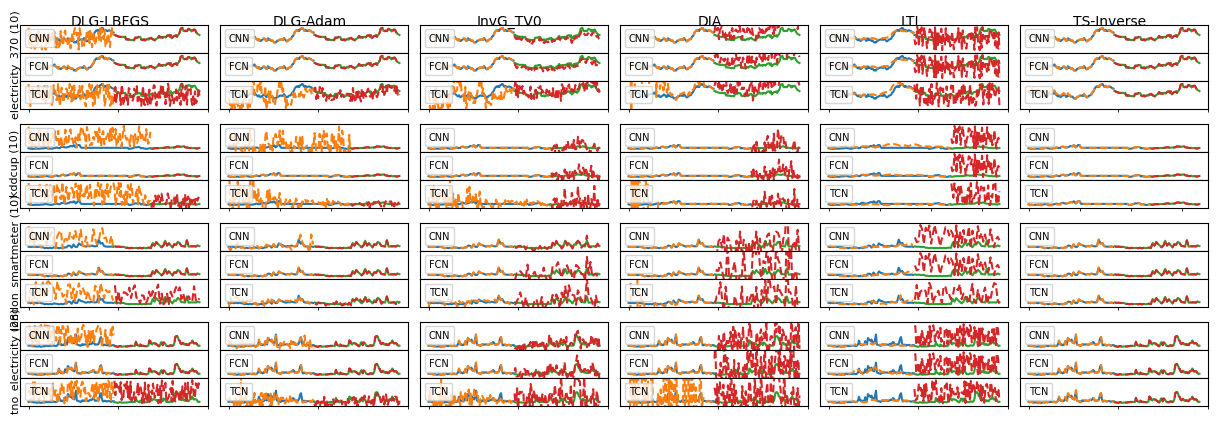

In [9]:
api = wandb.Api()
runs_baselines = api.runs("capsar-meijer/tno-fl-baselines-time-series")
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_baselines) + len(runs_ts_inverse)} runs')
filters = [
{
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA',
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
        'attack_method': lambda x: x == 'DIA',
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_gru_mse_learn_dilate_opti_1-5-2024', # GRU Results
        'inversion_regularization_term': lambda x: x == 0.01,
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_fcn_cnn_tcn_26-4-2024', # FCN, CNN, TCN Results
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    }
]
attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI', 'TS-Inverse']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

runs = [runs_baselines, runs_ts_inverse]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='attack_method', filters=filters, runs=runs, 
                                                                                                         variables_other_sorted=attack_methods_ordered_list)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, extra_title='ts-inverse_attack_method_x_dataset_x_model')

Found 5133 runs
Found 112 runs with metrics: {('kddcup', 'GRU', 'DIA'): [[1.8497356176376345, 1.297070860862732], [1.7428526878356934, 1.6252403259277344], [1.8817100524902344, 1.585038661956787]], ('tno_electricity', 'GRU', 'DIA'): [[1.6759202480316162, 1.4546566009521484], [1.8189605474472048, 1.516055941581726], [1.8042826652526855, 1.7185962200164795]], ('london_smartmeter', 'GRU', 'DIA'): [[1.7320650815963743, 1.5725297927856443], [1.470250964164734, 1.7130203247070312], [1.6120141744613647, 1.5780800580978394]], ('electricity_370', 'GRU', 'DIA'): [[1.063268542289734, 0.7418286204338074], [1.5772531032562256, 0.713267982006073], [1.3438657522201538, 0.4599038064479828]], ('kddcup', 'GRU', 'InvG_TV0'): [[1.6399391889572144, 1.6691381931304932], [1.8388005495071411, 1.7751010656356812], [1.580053210258484, 0.8427934646606445], [1.6553140878677368, 1.518346071243286], [1.8673714399337769, 1.4335025548934937]], ('tno_electricity', 'GRU', 'InvG_TV0'): [[1.622209072113037, 0.73985326290

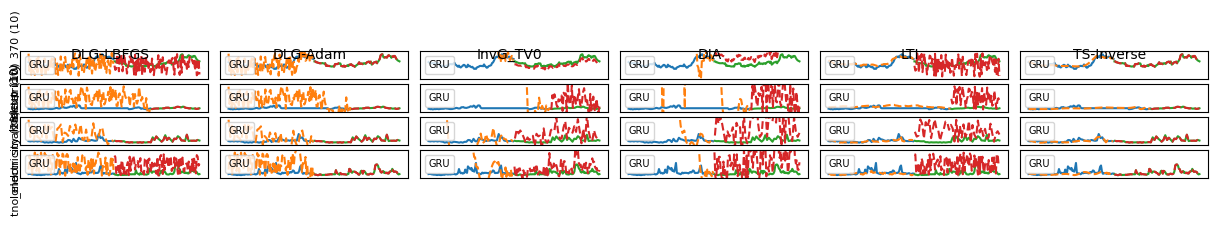

In [10]:
api = wandb.Api()
runs_baselines = api.runs("capsar-meijer/tno-fl-baselines-time-series")
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_baselines) + len(runs_ts_inverse)} runs')
filters = [
{
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA',
        'model': lambda x: 'GRU' in x,
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
        'attack_method': lambda x: x == 'DIA',
        'model': lambda x: 'GRU' in x,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_gru_mse_learn_dilate_opti_1-5-2024', # GRU Results
        'inversion_regularization_term': lambda x: x == 0.01,
        'model': lambda x: 'GRU' in x,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_fcn_cnn_tcn_26-4-2024', # FCN, CNN, TCN Results
        'model': lambda x: 'GRU' in x,
    }
]
attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI', 'TS-Inverse']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

runs = [runs_baselines, runs_ts_inverse]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='attack_method', filters=filters, runs=runs, 
                                                                                                         variables_other_sorted=attack_methods_ordered_list)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, extra_title='ts-inverse_attack_method_x_dataset_x_model')

# Baselines (No TS-Inverse) visuals for energy datasets

Found 3707 runs
dict_keys([('DIA', 'Electricity 370 (10)', 'TCN'), ('DIA', 'Electricity 370 (10)', 'FCN'), ('DIA', 'Electricity 370 (10)', 'CNN'), ('InvG', 'Electricity 370 (10)', 'TCN'), ('InvG', 'Electricity 370 (10)', 'FCN'), ('InvG', 'Electricity 370 (10)', 'CNN'), ('DLG-Adam', 'Electricity 370 (10)', 'TCN'), ('DLG-Adam', 'Electricity 370 (10)', 'FCN'), ('DLG-Adam', 'Electricity 370 (10)', 'CNN'), ('LTI', 'Electricity 370 (10)', 'TCN'), ('LTI', 'Electricity 370 (10)', 'CNN'), ('LTI', 'Electricity 370 (10)', 'FCN'), ('DLG-LBFGS', 'Electricity 370 (10)', 'TCN'), ('DLG-LBFGS', 'Electricity 370 (10)', 'FCN'), ('DLG-LBFGS', 'Electricity 370 (10)', 'CNN')])


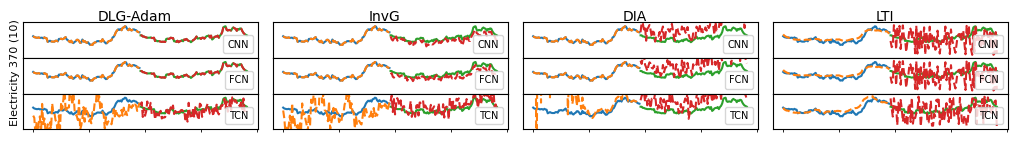

In [9]:
api = wandb.Api()
runs_baselines = api.runs("capsar-meijer/tno-fl-baselines-time-series")
print(f'Found {len(runs_baselines)} runs')
filters = [
{
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA',
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
        'attack_method': lambda x: x == 'DIA',
        'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    }
]
# attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI']


runs = runs_baselines

dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 10,
    # 'tno_electricity': 28,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
    'InvG_TV0': 'InvG',
}
attack_methods_ordered_list = ['DLG-Adam', 'InvG', 'DIA', 'LTI']

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, extra_title='baselines_attack_method_x_dataset_x_model_fcn_cnn_tcn', legend_loc='lower right', plot_size_width=2.5, plot_size_height=0.42)

# TS-Inverse

Found 1473 runs
dict_keys([('TS-Inverse', 'electricity_370 (10)', 'TCN'), ('TS-Inverse', 'kddcup (10)', 'GRU'), ('TS-Inverse', 'london_smartmeter (10)', 'GRU'), ('TS-Inverse', 'electricity_370 (10)', 'GRU'), ('TS-Inverse', 'tno_electricity (28)', 'GRU'), ('TS-Inverse', 'tno_electricity (28)', 'TCN'), ('TS-Inverse', 'tno_electricity (28)', 'FCN'), ('TS-Inverse', 'tno_electricity (28)', 'CNN'), ('TS-Inverse', 'kddcup (10)', 'TCN'), ('TS-Inverse', 'london_smartmeter (10)', 'TCN'), ('TS-Inverse', 'kddcup (10)', 'FCN'), ('TS-Inverse', 'london_smartmeter (10)', 'FCN'), ('TS-Inverse', 'electricity_370 (10)', 'FCN'), ('TS-Inverse', 'kddcup (10)', 'CNN'), ('TS-Inverse', 'london_smartmeter (10)', 'CNN'), ('TS-Inverse', 'electricity_370 (10)', 'CNN')])


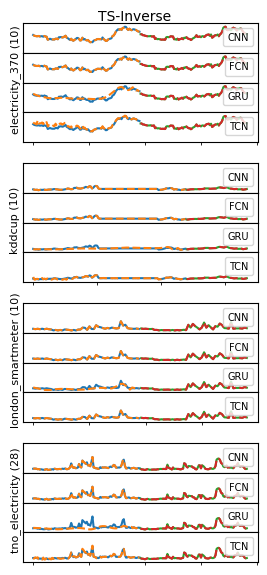

In [12]:
api = wandb.Api()
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_ts_inverse)} runs')
filters = [
    # {
    #     'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
    #     'attack_method': lambda x: x != 'DIA',
    #     'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    # },
    # {
    #     'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
    #     'attack_method': lambda x: x == 'DIA',
    #     'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    # },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_gru_mse_learn_dilate_opti_1-5-2024', # GRU Results
        'inversion_regularization_term': lambda x: x == 0.01,
        # 'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_fcn_cnn_tcn_26-4-2024', # FCN, CNN, TCN Results
        # 'model': lambda x: 'FCN' in x or 'CNN' in x or 'TCN' in x,
    }
]
attack_methods_ordered_list = ['TS-Inverse']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, extra_title='ts-inverse_attack_method_x_dataset_x_model', legend_loc='upper right', plot_size_width=2.5, plot_size_height=0.35)

# (TS-Inverse vs) DIA for increasing batch size

Found 5133 runs
dict_keys([(1, 'cosine_dia', 'DIA'), (8, 'cosine_dia', 'DIA'), (4, 'cosine_dia', 'DIA'), (2, 'cosine_dia', 'DIA')])


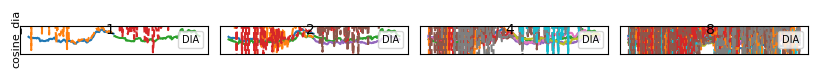

In [13]:
api = wandb.Api()
runs_baselines = api.runs("capsar-meijer/tno-fl-baselines-time-series")
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_baselines) + len(runs_ts_inverse)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_dia_batch_size_7-5-2024',
        'dropout': lambda x: x == 0.1,
    },
    # {
    #     'experiment_name': lambda x: x == 'ts-inverse_final_batch_size_tcn_ablation_8-5-2024', # GRU Results
    #     # 'gradient_loss': lambda x: x == '1_l1_0.0005_cosine',
    # },
]

dataset_seed_dict = {
    'electricity_370': 10,
}

runs = [runs_baselines, runs_ts_inverse]

# metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='batch_size', rows='gradient_loss', 
#                                                                                                          metric=SMAPELoss, 
#                                                                                                          variable='attack_method', filters=filters, runs=runs)
# print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='batch_size', rows='gradient_loss', variables='attack_method', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dia_batch_size_dropout_x_batch_size_x_attack_method', legend_loc='upper right')

# reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='batch_size', rows='attack_method', variables='batch_size', filters=filters, runs=runs)
# plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dia_batch_size_dropout_x_batch_size_x_attack_method', legend_loc='upper right')

# Archive

# FCN, CNN, TCN Gradient Optimization Loss Ablation
Settings: seed = 10, B = 1, models = [FCN, CNN, TCN]

TCN is undeterministic in these runs so should be ignored.

NOT USED IN PAPER

Found 1473 runs
Found 120 runs with metrics: {('kddcup', 'FCN', '0.1_l1_1_cosine'): [[6.420990672495465e-08, 1.071041282330043e-07]], ('tno_electricity', 'FCN', '0.1_l1_1_cosine'): [[5.619169314741157e-06, 2.560313760113786e-06]], ('london_smartmeter', 'FCN', '0.1_l1_1_cosine'): [[1.0422480045235716e-05, 4.7541548156004865e-06]], ('electricity_370', 'FCN', '0.1_l1_1_cosine'): [[1.037823125216164e-07, 3.5145014010140585e-08]], ('kddcup', 'CNN', '0.1_l1_1_cosine'): [[0.009460745379328728, 5.5633798183407634e-05]], ('tno_electricity', 'CNN', '0.1_l1_1_cosine'): [[0.013621143065392973, 9.26473512663506e-05]], ('london_smartmeter', 'CNN', '0.1_l1_1_cosine'): [[0.0001502746599726379, 5.5282587709371e-05]], ('electricity_370', 'CNN', '0.1_l1_1_cosine'): [[0.0013092856388539076, 6.7204337028670125e-06]], ('kddcup', 'FCN', '0.1_fcn-l1_1_cosine'): [[6.320469481124746e-08, 1.104200961776769e-07]], ('tno_electricity', 'FCN', '0.1_fcn-l1_1_cosine'): [[1.0577722378002363e-06, 4.830129114452575e-07]]

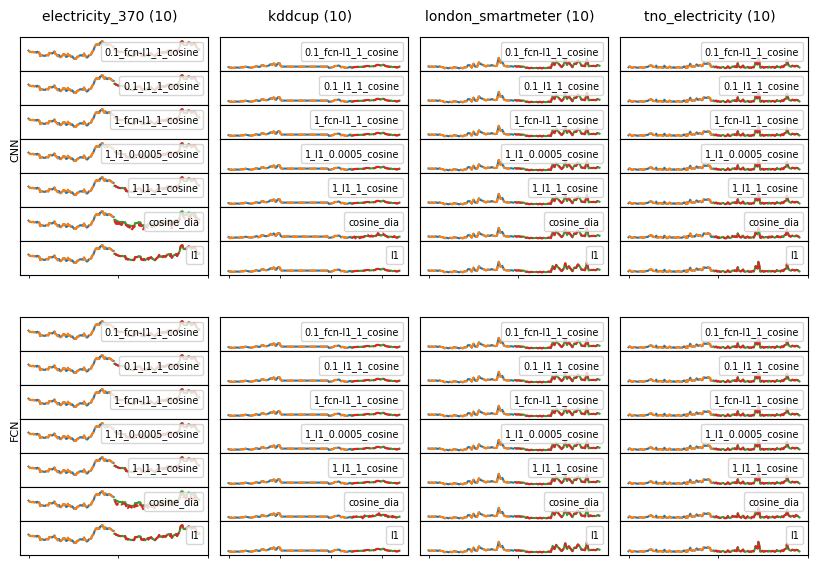

dict_keys([('Electricity 370 (10)', 'FCN', 'Cosine'), ('Electricity 370 (10)', 'CNN', 'Cosine'), ('Electricity 370 (10)', 'FCN', 'L1'), ('Electricity 370 (10)', 'CNN', 'L1')])


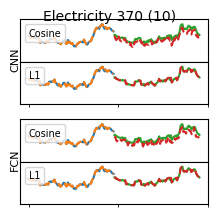

In [14]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [

    {
        'experiment_name': lambda x: x == 'ts-inverse_gradient_loss_ablation_10-5-2024',
        'model': lambda x: 'FCN' in x or 'CNN' in x,
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gradient_loss_ablation', legend_loc='upper right', plot_size_height=0.4)

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_gradient_loss_ablation_10-5-2024',
        'model': lambda x: 'FCN' in x or 'CNN' in x,
        'gradient_loss': lambda x: x == 'cosine_dia' or x == 'l1',
    }
]
dataset_seed_dict = {
    'electricity_370': 10,
    # 'kddcup': 10,
    # 'london_smartmeter': 10,
    # 'tno_electricity': 10,
}
replace_dict = {
    'electricity_370': 'Electricity 370',
    'london_smartmeter': 'London Smartmeter',
    'tno_electricity': 'TNO Electricity',
    'kddcup': 'KDDCup',
    'cosine_dia': 'Cosine',
    'l1': 'L1',
}
reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs, replace_dict=replace_dict)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_show_difference_between_cosine_l1_batch_size_1', legend_loc='upper left', plot_size_height=0.5)

# FCN, CNN, and TCN Comparison with gradient losses with batch size = 2
NOT USED IN PAPER BECAUSE TCN IS UNDETERMINISTIC

Found 1473 runs
Found 36 runs with reconstructions
['electricity_370', 'kddcup', 'london_smartmeter', 'tno_electricity'] ['CNN', 'FCN', 'TCN'] ['1_l1_0.0005_cosine', 'cosine_dia', 'l1']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{kddcup} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Gradient Loss & Input & Target           & Input & Target           & Input & Target           & Input & Target \\
\midrule
CNN	& 1_l1_0.0005_cosine	 & \textbf{0.100} & 0.417 & \textbf{0.438} & 0.856 & 0.423 & 0.640 & 0.296 & \textbf{0.821} \\
	& cosine_dia	 & 0.101 & \textbf{0.414} & 0.563 & 1.005 & 0.456 & 0.834 & 0.313 & 0.902 \\
	& l1

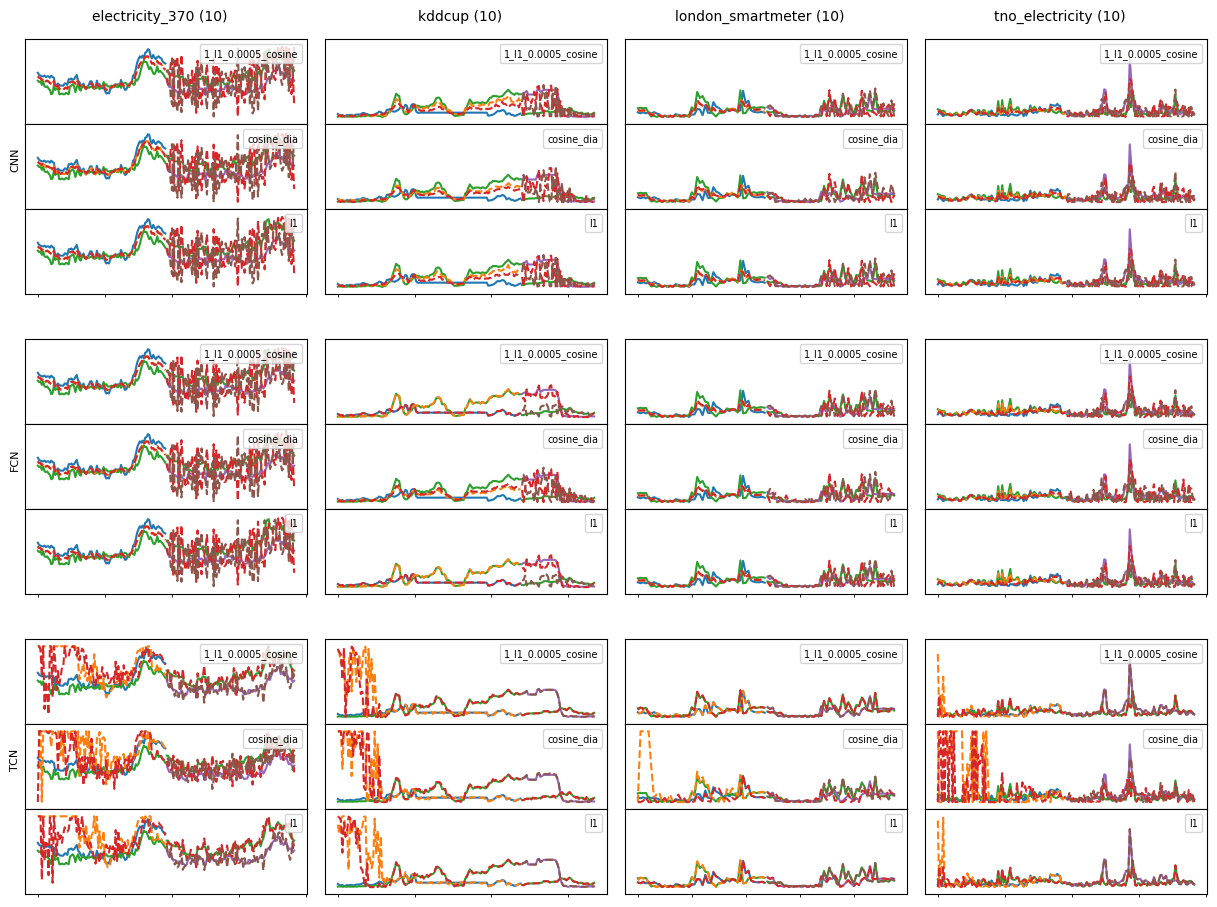

In [15]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_gradient_loss_x_batch_size_9-5-2024', # Cosine_dia, L1 and 1_l1 + 0.0005_cosine
    },
]

specific_seed = 10
metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='model', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gradient_loss_batch_size_2_ablation', plot_size_width=3, plot_size_height=1, legend_loc='upper right')

## OLD: TS-Inverse experiment for gradient_loss x inversion_regularization_term x batch_size

Loss function is not just L1, it is the L1 + 0.0005 Cosine

Found 1473 runs
Found 64 runs with reconstructions
['electricity_370', 'kddcup', 'london_smartmeter', 'tno_electricity'] ['1', '2', '4', '8'] ['-1', '0', '0.0001', '0.01']
\begin{table*}[]
\centering
\resizebox{\linewidth}{!}{
\begin{tabular}{l|l|cc|cc|cc|cc}
\toprule
      & Dataset                 & \multicolumn{2}{c}{Electricity 370} & \multicolumn{2}{c}{KDDCup} & \multicolumn{2}{c}{London Smartmeter} & \multicolumn{2}{c}{TNO Electricity} \\
      & REPLACE                 & \multicolumn{2}{c}{electricity_370} & \multicolumn{2}{c}{kddcup} & \multicolumn{2}{c}{london_smartmeter} & \multicolumn{2}{c}{tno_electricity} \\
\midrule
Model & Prior Reg. $\tau$ & Input & Target           & Input & Target           & Input & Target           & Input & Target \\
\midrule
1	& -1	 & 0.050 & \textbf{4.0e-04} & 0.284 & 0.008 & 0.111 & 0.018 & \textbf{0.153} & 0.005 \\
	& 0	 & 0.051 & 5.2e-04 & 0.223 & 0.012 & \textbf{0.035} & 0.006 & 0.232 & 0.006 \\
	& 0.0001	 & 0.087 & 4.6e-04 & 0.188 & 0.004 & 

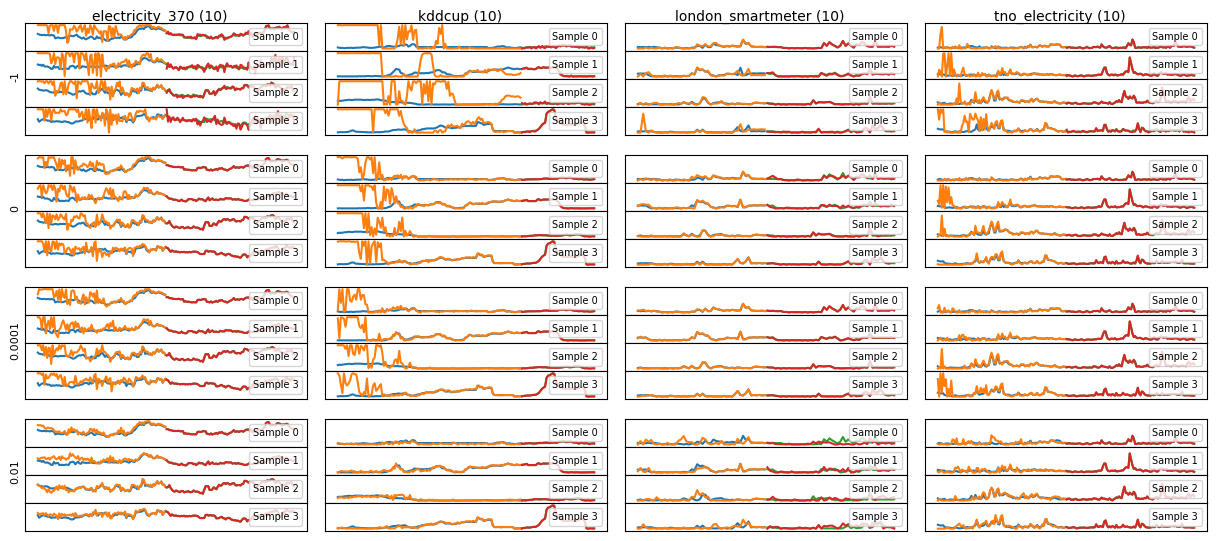

In [16]:
api = wandb.Api()
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_ts_inverse)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_x_inv_x_batch_size_10-5-2024', # L1 + 0.0005 Cosine
    },    
]

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

runs = runs_ts_inverse

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_from_reconstructions_by_parameters(columns='dataset', rows='batch_size', 
                                                                                                         metric=SMAPELoss, 
                                                                                                         variable='inversion_regularization_term', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Prior Reg. $\\tau$')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_tcn_dataset_x_inv_x_batch_size_10-5-2024',
        # 'num_learn_epochs': lambda x: x == 50, 
        'batch_size': lambda x: x == 4,
    },    
]

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='inversion_regularization_term', variables='batch_size', filters=filters, runs=runs)
plot_multi_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_batch_size_x_inversion_regularization_ablation', plot_size_width=3, plot_size_height=0.33, legend_loc='upper right')

## Not Useful: Experiment with Double loss and learning rate adjustment

Found 1473 runs
Found 160 runs with metrics: {('kddcup', 'GRU', 'ts-inverse_final_double_loss_lr_23-4-2024'): [[1.023591160774231, 9.79781470960006e-05], [0.5977398157119751, 0.0003281220269855112], [1.3972278833389282, 1.5798694221302867e-05], [1.1474004983901978, 4.598837222147267e-06], [0.4507189989089966, 6.63853370497236e-06]], ('tno_electricity', 'GRU', 'ts-inverse_final_double_loss_lr_23-4-2024'): [[1.522929549217224, 6.421648140531033e-05], [1.0095832347869873, 2.034053613897413e-05], [1.4592970609664917, 2.755620334937703e-05], [1.1681774854660034, 3.34473152179271e-05], [0.6363717317581177, 1.8529513909015805e-05]], ('london_smartmeter', 'GRU', 'ts-inverse_final_double_loss_lr_23-4-2024'): [[1.1730839014053345, 7.806849316693842e-05], [1.248161792755127, 0.00019673431233968583], [1.4477179050445557, 0.00010473962174728511], [1.241699457168579, 0.00012713481555692852], [1.5512571334838867, 0.00015506427735090256]], ('electricity_370', 'GRU', 'ts-inverse_final_double_loss_lr_23

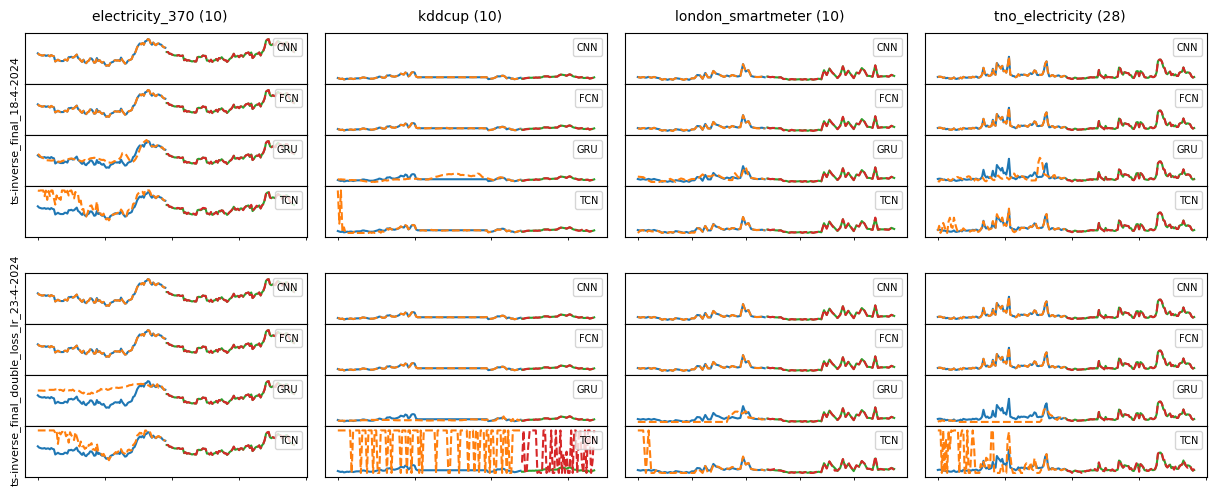

In [17]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_double_loss_lr_23-4-2024',
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_18-4-2024',
        'num_attack_steps': lambda x: x == 5000,
    },
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='experiment_name', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='experiment_name', variables='model', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_double_loss', plot_size_width=3, plot_size_height=0.6, column_offset=0.0, legend_loc='upper right')

## OLD: TS-Inverse Gradient_loss x dropout probability regularizer for TCN

Replaced with: ts-inverse_tcn_l1_dataset_x_batch_size_x_dropout_reg_12-5-2024

Found 1473 runs
Found 24 runs with metrics: {('kddcup', '1e-07', '1_l1_0.00005_cosine'): [[0.2206830084323883, 0.008775290101766586]], ('tno_electricity', '1e-07', '1_l1_0.00005_cosine'): [[0.17989158630371094, 0.0037154825404286385]], ('london_smartmeter', '1e-07', '1_l1_0.00005_cosine'): [[0.1237598955631256, 0.026484552770853043]], ('electricity_370', '1e-07', '1_l1_0.00005_cosine'): [[0.04032490402460098, 0.00036242068745195866]], ('kddcup', '1e-06', '1_l1_0.00005_cosine'): [[0.24677959084510803, 0.00817040540277958]], ('tno_electricity', '1e-06', '1_l1_0.00005_cosine'): [[0.2212835997343063, 0.0050508687272667885]], ('london_smartmeter', '1e-06', '1_l1_0.00005_cosine'): [[0.12131468951702118, 0.02737325057387352]], ('electricity_370', '1e-06', '1_l1_0.00005_cosine'): [[0.04581068083643913, 0.00044660535058937967]], ('kddcup', '1e-05', '1_l1_0.00005_cosine'): [[0.2303686887025833, 0.008733002468943596]], ('tno_electricity', '1e-05', '1_l1_0.00005_cosine'): [[0.19154247641563416, 0.

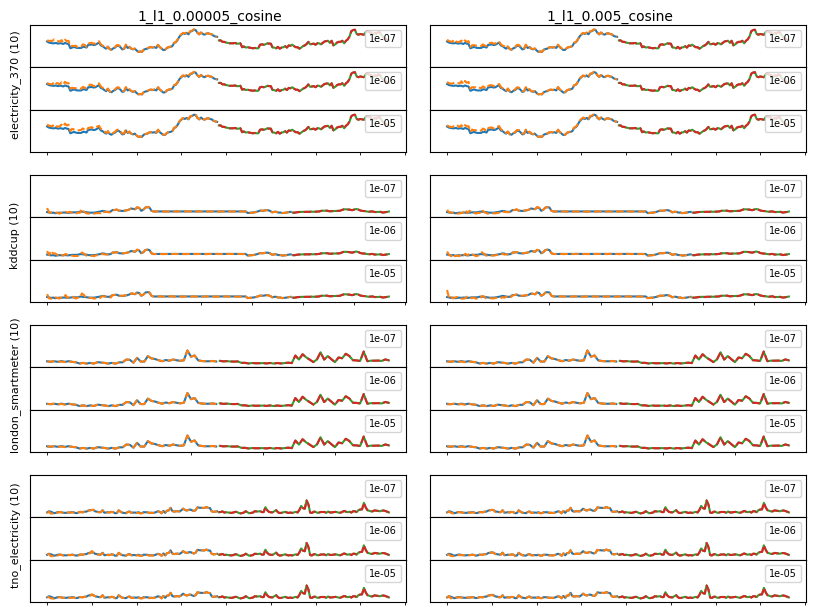

In [18]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_f1_cosine_loss_and_regularize_2_24-4-2024',
        'grad_signs_for_dropouts': lambda x: x == True,
    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='dropout_probability_regularizer', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Dropout Regularizer')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='gradient_loss', rows='dataset', variables='dropout_probability_regularizer', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gradient_loss_x_dropout_regularizer', plot_size_width=4, plot_size_height=0.5, legend_loc='upper right')

## OLD: Reconstructions of TS-Inverse & Baselines: Attack Method x Dataset x Model

Found 5133 runs
Found 480 runs with metrics: {('kddcup', 'GRU', 'DIA'): [[1.8497356176376345, 1.297070860862732], [1.7428526878356934, 1.6252403259277344], [1.8817100524902344, 1.585038661956787]], ('tno_electricity', 'GRU', 'DIA'): [[1.6759202480316162, 1.4546566009521484], [1.8189605474472048, 1.516055941581726], [1.8042826652526855, 1.7185962200164795]], ('london_smartmeter', 'GRU', 'DIA'): [[1.7320650815963743, 1.5725297927856443], [1.470250964164734, 1.7130203247070312], [1.6120141744613647, 1.5780800580978394]], ('electricity_370', 'GRU', 'DIA'): [[1.063268542289734, 0.7418286204338074], [1.5772531032562256, 0.713267982006073], [1.3438657522201538, 0.4599038064479828]], ('kddcup', 'TCN', 'DIA'): [[1.009507417678833, 1.1360409259796145], [0.6124587059020996, 1.3130885362625122], [0.5623816251754761, 1.237692952156067]], ('tno_electricity', 'TCN', 'DIA'): [[1.6152377128601074, 1.4139403104782104], [1.4178012609481812, 1.4642947912216189], [0.8136758208274841, 1.5412153005599976]], 

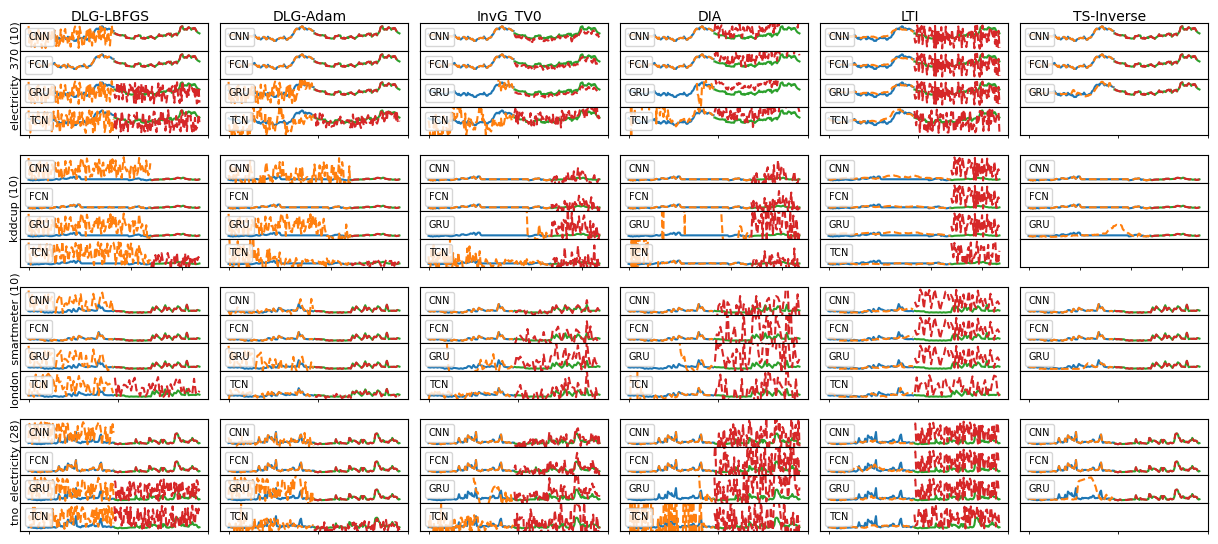

In [19]:
api = wandb.Api()
runs_baselines = api.runs("capsar-meijer/tno-fl-baselines-time-series")
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_baselines) + len(runs_ts_inverse)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'baselines_final_18-4-2024',
        'attack_method': lambda x: x != 'DIA',
    },
    {
        'experiment_name': lambda x: x == 'baselines_final_dia_lr_schedular_fix_23-4-2024',
        'attack_method': lambda x: x == 'DIA',
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_18-4-2024', # CNN Results
        'num_attack_steps': lambda x: x == 5000,
        'model': lambda x: x == 'CNN_Predictor',
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_23-4-2024',  # FCN Results
        'num_attack_steps': lambda x: x == 5000,
        'model': lambda x: x == 'FCN_Predictor',
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_f1_cosine_loss_and_regularize_2_24-4-2024', # TCN Results
        'gradient_loss': lambda x: x == '1_l1_0.0005_cosine',
        'dropout_probability_regularizer': lambda x: x == 1e-6,
    },
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_gru_and_regularize_24-4-2024' # GRU Results
    }

]
attack_methods_ordered_list = ['DLG-LBFGS', 'DLG-Adam', 'InvG_TV0', 'DIA', 'LTI', 'TS-Inverse']
# attack_methods_ordered_list = ['DIA', 'LTI', 'TS-Inverse']

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

runs = [runs_baselines, runs_ts_inverse]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='attack_method', filters=filters, runs=runs, 
                                                                                                         variables_other_sorted=attack_methods_ordered_list)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='attack_method', rows='dataset', variables='model', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, attack_methods_ordered_list, u_rows, u_variables, extra_title='ts-inverse_attack_method_x_dataset_x_model')

## OLD: TS-Inverse TCN batch_size x dropout reg x dataset (Elec 370 & London) seed 10

Replaced with: ts-inverse_tcn_l1_dataset_x_batch_size_x_dropout_reg_12-5-2024

Found 1473 runs
Found 40 runs with metrics: {('8', 'london_smartmeter', '0.0001'): [[1.3745896816253662, 1.166548252105713]], ('8', 'electricity_370', '0.0001'): [[0.6724824905395508, 0.5483693480491638]], ('4', 'london_smartmeter', '0.0001'): [[1.1228201389312744, 1.108370304107666]], ('4', 'electricity_370', '0.0001'): [[0.4155079126358032, 0.2947152256965637]], ('2', 'london_smartmeter', '0.0001'): [[0.6398667693138123, 0.6473190784454346]], ('2', 'electricity_370', '0.0001'): [[0.33983373641967773, 0.046986013650894165]], ('1', 'london_smartmeter', '0.0001'): [[0.1367902010679245, 0.02575714141130447]], ('1', 'electricity_370', '0.0001'): [[0.044211603701114655, 0.0005924557917751372]], ('8', 'london_smartmeter', '1e-05'): [[1.2502973079681396, 1.041093826293945]], ('8', 'electricity_370', '1e-05'): [[0.6467022895812988, 0.5643667578697205]], ('4', 'london_smartmeter', '1e-05'): [[1.151609182357788, 0.9370330572128296]], ('4', 'electricity_370', '1e-05'): [[0.4120731055736542, 0.32

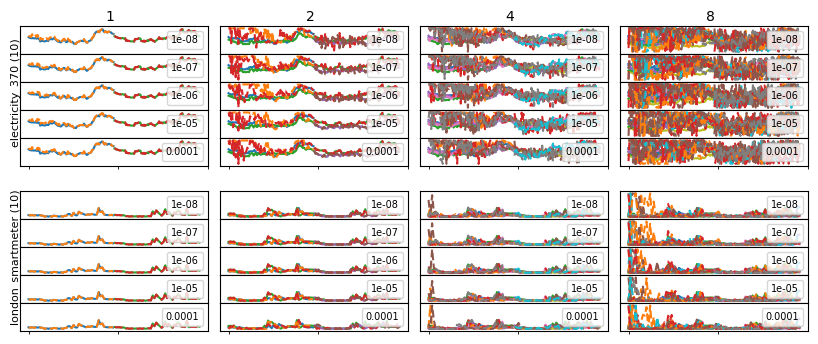

In [20]:
api = wandb.Api()
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_ts_inverse)} runs')
filters = [
{
        'experiment_name': lambda x: x == 'ts-inverse_tcn_batch_size_dropout_reg_9-5-2024',
    },
]

dataset_seed_dict = {
    'electricity_370': 10,
    'london_smartmeter': 10,
}

runs = runs_ts_inverse

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='batch_size', rows='dataset', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='dropout_probability_regularizer', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='batch_size', rows='dataset', variables='dropout_probability_regularizer', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_batch_size_x_dropout_regularizer', legend_loc='upper right')

# TS-Inverse TCN $L1 + \xi cos$ term x dataset x model

Could be used for additional experiments

Found 1473 runs
Found 48 runs with metrics: {('kddcup', 'FCN', '1_l1_0.00005_cosine'): [[4.4376424739311915e-06, 1.3524521591534722e-06]], ('tno_electricity', 'FCN', '1_l1_0.00005_cosine'): [[6.2022254496696405e-06, 2.4726000447117258e-06]], ('london_smartmeter', 'FCN', '1_l1_0.00005_cosine'): [[1.0439993275213055e-05, 3.1943504836817738e-06]], ('electricity_370', 'FCN', '1_l1_0.00005_cosine'): [[3.6786431678592635e-07, 1.44407550806136e-07]], ('kddcup', 'CNN', '1_l1_0.00005_cosine'): [[0.009095299988985062, 7.132289465516806e-05]], ('tno_electricity', 'CNN', '1_l1_0.00005_cosine'): [[0.012249676510691644, 9.134355059359224e-05]], ('london_smartmeter', 'CNN', '1_l1_0.00005_cosine'): [[0.0003242945531383157, 8.659713057568297e-05]], ('electricity_370', 'CNN', '1_l1_0.00005_cosine'): [[0.0011362226214259865, 6.860948815301526e-06]], ('kddcup', 'FCN', '1_l1_0.0005_cosine'): [[3.980684414273128e-05, 1.4446939530898815e-05]], ('tno_electricity', 'FCN', '1_l1_0.0005_cosine'): [[7.64144431286

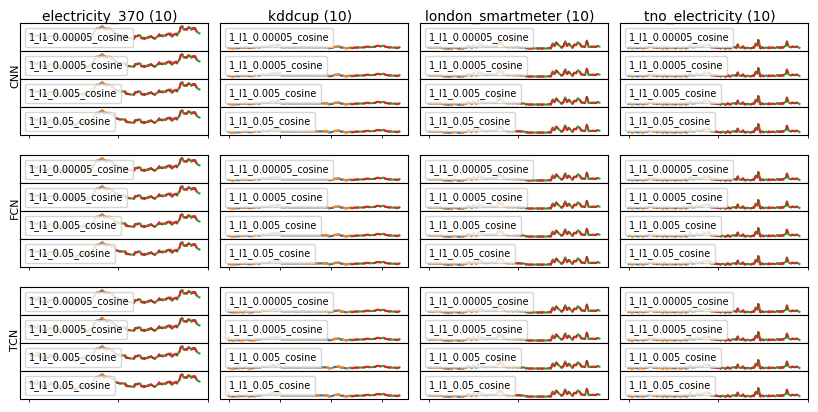

In [21]:
api = wandb.Api()
runs_ts_inverse = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs_ts_inverse)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_l1_cos_term_9-5-2024',
    },
]

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 10,
}

runs = runs_ts_inverse

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)
print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='gradient_loss', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_dataset_x_batch_size_x_gradient_loss')

# GRU Experiments

## TS-Inverse for inversion_regularization_term X Dataset X GRU

Found 1473 runs
Found 60 runs with metrics: {('kddcup', 'GRU', '0.01'): [[0.3819800317287445, 8.624514885013923e-05], [0.8556475639343262, 0.0003966159129049629], [0.8423828482627869, 0.000945269304793328], [0.8050767183303833, 2.7055662940256298e-05], [0.664526641368866, 0.00011021150567103176]], ('tno_electricity', 'GRU', '0.01'): [[0.638103187084198, 0.0001731229422148317], [0.6020382642745972, 0.00010808662045747042], [0.48535335063934326, 0.00012878995039500296], [0.5284014940261841, 7.456482126144692e-05], [0.6127398014068604, 0.00012674194294959307]], ('london_smartmeter', 'GRU', '0.01'): [[0.6875032186508179, 3.4425174817442894e-05], [0.8652359247207642, 0.00022480502957478168], [0.4960491359233856, 0.0001246952306246385], [0.6313153505325317, 0.00047562981490045786], [0.7872831225395203, 0.00023809423146303743]], ('electricity_370', 'GRU', '0.01'): [[0.08936821669340134, 7.691370228712913e-06], [0.11138246953487396, 2.4574430426582697e-05], [0.17309889197349548, 1.582709774083

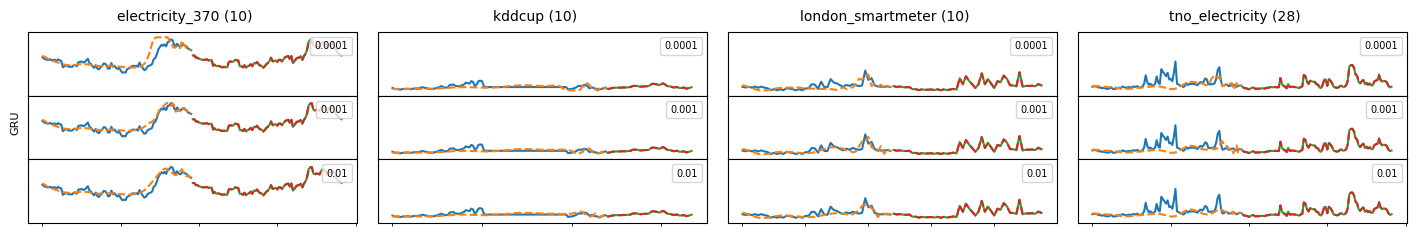

In [22]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')
filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_final_gru_mse_learn_dilate_opti_1-5-2024', # GRU Results
    }
]
dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

inversion_regularization_metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='model', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='inversion_regularization_term', filters=filters, runs=runs)
print_latex_table_input_target(inversion_regularization_metric_table, u_columns, u_rows, u_variables)

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='model', variables='inversion_regularization_term', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gru_regularization_terms_dilate', plot_size_width=3.5, plot_size_height=0.75, column_offset=0.0, legend_loc='upper right')

## Not Useful: GRU Comparison of loss functions and signed gradients for TS-Inverse.

Found 1473 runs
Found 72 runs with metrics: {('kddcup', 'True', 'l1_cosine_dia'): [[1.7780905961990356, 0.02132929675281048], [1.270540714263916, 0.05395776778459549], [1.2805333137512207, 0.033864229917526245]], ('tno_electricity', 'True', 'l1_cosine_dia'): [[1.3229118585586548, 0.04210323095321655], [1.7303690910339355, 0.055235475301742554], [0.7865311503410339, 0.07917451113462448]], ('london_smartmeter', 'True', 'l1_cosine_dia'): [[1.4244054555892944, 0.19098559021949768], [1.3726552724838257, 0.11055377125740053], [0.9868143796920776, 0.18994443118572235]], ('electricity_370', 'True', 'l1_cosine_dia'): [[0.6439828872680664, 0.004175358451902866], [1.0615969896316528, 0.007125747390091419], [0.5453425645828247, 0.0053467219695448875]], ('kddcup', 'False', 'l1_cosine_dia'): [[1.3308370113372805, 0.013795753940939903], [1.0004085302352903, 0.018228663131594654], [1.1768893003463743, 0.02633146196603775]], ('tno_electricity', 'False', 'l1_cosine_dia'): [[1.0962316989898682, 0.0640275

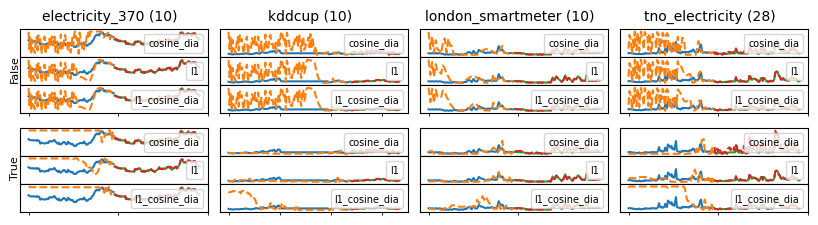

In [23]:
dotenv.load_dotenv()
api = wandb.Api()
runs = api.runs("capsar-meijer/tno-fl-ts-inverse")
print(f'Found {len(runs)} runs')

filters = [
    {
        'experiment_name': lambda x: x == 'ts-inverse_loss_ablation_22-4-2024',
        # 'use_grad_signs': lambda x: x == True, # or False

    }
]

metric_table, u_columns, u_rows, u_variables = gather_final_metrics_by_parameters(columns='dataset', rows='use_grad_signs', 
                                                                                                         metrics=['inputs/smape/mean', 'targets/smape/mean'], 
                                                                                                         variable='gradient_loss', filters=filters, runs=runs)

print_latex_table_input_target(metric_table, u_columns, u_rows, u_variables, variable_name='Gradient Loss')

dataset_seed_dict = {
    'electricity_370': 10,
    'kddcup': 10,
    'london_smartmeter': 10,
    'tno_electricity': 28,
}

reconstruction_dict, u_columns, u_rows, u_variables  = gather_run_reconstructions(dataset_seed=dataset_seed_dict, columns='dataset', rows='use_grad_signs', variables='gradient_loss', filters=filters, runs=runs)
plot_single_batch_reconstructions_in_grid(reconstruction_dict, u_columns, u_rows, u_variables, extra_title='ts-inverse_gradient_loss_and_grad_signs', column_offset=0.1, legend_loc='upper right')